In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

In [2]:
spark = SparkSession.builder.appName('location based recommandation').getOrCreate()

In [3]:
# already chose city in part1, so drop unneccessary columns
business = spark.read.csv('business.csv',header=True)
business = business.drop('city','state','is_open')

In [4]:
# column type convertion
business = business.withColumn('latitude',business['latitude'].cast('double'))
business = business.withColumn('longitude',business['longitude'].cast('double'))
business = business.withColumn('review_count',business['review_count'].cast('int'))
business = business.withColumn('stars',business['stars'].cast('int'))

In [8]:
# plot initial graph
px.set_mapbox_access_token("pk.eyJ1IjoiYmFueGlhbiIsImEiOiJja3YwcDVxNWs3b2x1MndxNmhmNTF4bGllIn0.-XUGN8rlW6vz9yIP6RKl-A")
fig = px.scatter_mapbox(business.toPandas(), lat="latitude", lon="longitude", size='review_count',size_max=15, zoom=10,color_continuous_scale=px.colors.diverging.Portland_r)
fig.update_layout(autosize=True,mapbox_style="carto-darkmatter",mapbox=dict(accesstoken=token,bearing=0))
fig.show()

# K-Means

In [9]:
vc = VectorAssembler(inputCols=['latitude','longitude'],outputCol="features")
dataset = vc.transform(business)
evaluator = ClusteringEvaluator(metricName='silhouette')

# candidate K 
Ks = 31
# two way to measure the performance of KMeans
# sum of squared error within cluster
sse = []
# Silhouette Score
sil = []

for i in range(2,Ks):
    kmeans = KMeans().setK(i).setSeed(2021)
    model = kmeans.fit(dataset)
    sse.append(model.summary.trainingCost)
    output = model.transform(dataset)
    score = evaluator.evaluate(output)
    sil.append(score)

In [10]:
def kmeans_plt(y,y_label,y_title):
    x = range(2,31)
    x_label = 'K'
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xticks(x)
    plt.plot(x, y, marker='o')
    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(y_label, fontsize = 14)
    plt.title(y_title, fontsize = 16)
    plt.show()

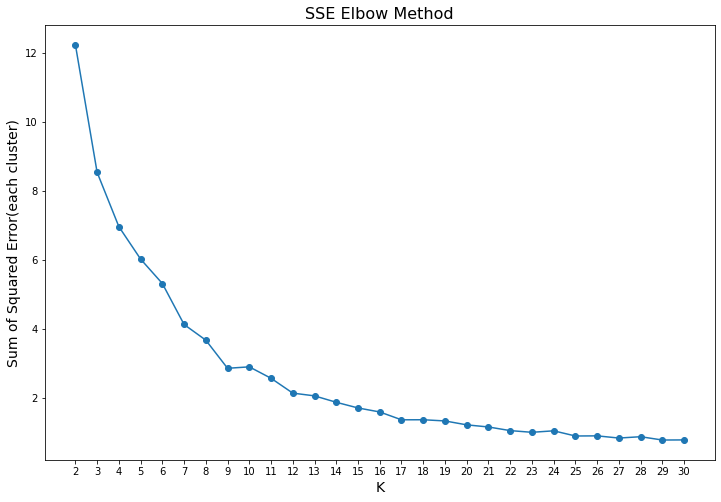

In [11]:
kmeans_plt(sse,'Sum of Squared Error(each cluster)','SSE Elbow Method')

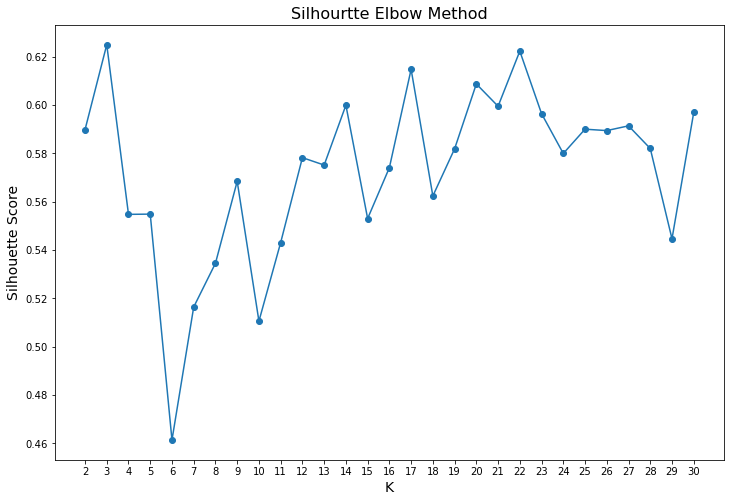

In [12]:
kmeans_plt(sil,'Silhouette Score','Silhourtte Elbow Method')

In [13]:
final_K = 14
kmeans_final = KMeans().setK(final_K).setSeed(2021)
kmeans_model = kmeans_final.fit(dataset)
prediction = kmeans_model.transform(dataset)

In [28]:
#px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
token = "pk.eyJ1IjoiYmFueGlhbiIsImEiOiJja3YwcDVxNWs3b2x1MndxNmhmNTF4bGllIn0.-XUGN8rlW6vz9yIP6RKl-A"
fig = px.scatter_mapbox(prediction.toPandas(), lat="latitude", lon="longitude", color="prediction", size='review_count', 
                  hover_data= ['name'], zoom=10,color_continuous_scale=px.colors.diverging.Portland_r)
fig.update_layout(autosize=True,mapbox_style="carto-darkmatter",mapbox=dict(accesstoken=token,bearing=0))
fig.show()

In [78]:
# get cluster
def get_label(latitude,longtitude):
    col = ['latitude','longitude']
    vc = VectorAssembler(inputCols=col,outputCol="features")
    new_user = spark.createDataFrame([(latitude,longtitude)],col)
    input_data = vc.transform(new_user)
    res = kmeans_model.transform(input_data)
    return res.select('prediction').collect()[0][0]
# choose top 10 resautant(order by stars) in the target cluster
def location_based_recommand(latitude,longtitude):
    cluster = get_label(latitude,longtitude)
    tmp = prediction.filter(prediction['prediction'] == cluster)
    return tmp.orderBy('stars',ascending=False).limit(10)
    

In [85]:
# test
a=prediction.sample(False,0.1).limit(1)
a.show()
location_based_recommand(a.select('latitude','longitude').collect()[0][0],a.select('latitude','longitude').collect()[0][1]).show()

+--------------------+---------------+-----+------------+--------------------+----------+------------+-----------+--------------------+----------+
|         business_id|           name|stars|review_count|          categories|  latitude|   longitude|postal_code|            features|prediction|
+--------------------+---------------+-----+------------+--------------------+----------+------------+-----------+--------------------+----------+
|SRHQEF2-VPS_dl1_Z...|Laughing Planet|    3|         155|Juice Bars & Smoo...|45.4789575|-122.6202643|      97255|[45.4789575,-122....|         8|
+--------------------+---------------+-----+------------+--------------------+----------+------------+-----------+--------------------+----------+

+--------------------+--------------------+-----+------------+--------------------+------------+---------------+-----------+--------------------+----------+
|         business_id|                name|stars|review_count|          categories|    latitude|      longi